In [0]:
import torch, torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tqdm
import os

This notebook accompanies the [week15] practice. Refer to the classwork for more details.


Your last and ultimate task is to implement and train __Convolutional Conditional VAE__. Simple VAE is available in week 15. For details about conditional VAE one can refer to [week 15 lecture](https://github.com/ml-mipt/ml-mipt/tree/advanced/week15_generative) or [this habr post (ru)](https://habr.com/ru/post/331664/)

If it seems too easy, you can use [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset instead of MNIST.

The code in general duplicates the one from the in-class practice. 

Do not forget to __use GPU acceleration during training__.

In [0]:
%matplotlib inline

In [3]:
from torchsummary import summary
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

__Currently you are using device:__

In [5]:
print(device)

cuda:0


In [0]:
# It's dangerous to walk alone. Take these ;)

class Rescale(object):
    def __call__(self, image):
        image = image - image.min()
        image = image/image.max()

        return image
    
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1, end_dim=-1)


class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape
        
    def forward(self, x):
        return x.view([-1]+list(self.initial_shape))

__Data loading stuff is done for you ;)__

In [0]:
mnist_transformations = transforms.Compose([
    transforms.ToTensor(),
    Rescale()
])

In [0]:
BATCH_SIZE = 256
SHUFFLE_DATASET = True
NUM_DATALOADER_WORKERS = 1

In [0]:
data_root = './'

In [0]:
train_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=True,
        transform=mnist_transformations,
        download=True
    ),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DATASET,
    num_workers=NUM_DATALOADER_WORKERS
)

In [0]:
test_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=False,
        transform=mnist_transformations
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS
)

__The code below is simple VAE. Your task is to make in convolutional (both encoder and decoder) and add class label information.__

apply MaxPool2d after each conv2d in encoder 

In [0]:
class ConvolutionalCVAE(nn.Module):
    def __init__(self, intermediate_dims, latent_dim, input_shape):
        super().__init__()
        self.register_buffer('_initial_mu', torch.zeros((latent_dim)))
        self.register_buffer('_initial_sigma', torch.ones((latent_dim)))

        self.latent_distribution = torch.distributions.normal.Normal(
            loc=self._initial_mu,
            scale=self._initial_sigma
        )
        input_dim = np.prod(input_shape)

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
            nn.Conv2d(3, 6, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
            nn.Conv2d(6, 12, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            Flatten(),
            
        )
        
        self.enc_lin = nn.Linear(1, 3)
        self.mu_repr = nn.Linear(intermediate_dims[1], latent_dim)
        self.log_sigma_repr = nn.Linear(intermediate_dims[1], latent_dim)

        self.decoder = nn.Sequential(
          nn.Linear(latent_dim + 3, 98),
          nn.LeakyReLU(),
          RestoreShape((2, 7, 7)),
          nn.Conv2d(2, 4, kernel_size = 3, stride = 1, padding = 1),
          nn.LeakyReLU(),
          nn.BatchNorm2d(4),
          nn.Dropout(0.3),
          nn.Conv2d(4, 16, kernel_size = 3, stride = 1, padding = 1),
          nn.LeakyReLU(),
          nn.BatchNorm2d(16),
          nn.Dropout(0.3),
          nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
          nn.LeakyReLU(),
          nn.BatchNorm2d(16),
          nn.Sigmoid(),
          RestoreShape(input_shape),
          
        )
        
        self.dec_lin = nn.Linear(1, 3)
        self.fc = nn.Linear(111, intermediate_dims[1])

    def _encode(self, x, label):
        conc = torch.cat([self.encoder(x), 
                                      self.enc_lin(label)], dim=-1)
        
        latent_repr =  self.fc(conc)

        mu_values = self.mu_repr(latent_repr)
        log_sigma_values = self.log_sigma_repr(latent_repr)
        return mu_values, log_sigma_values, latent_repr
    
    def _reparametrize(self, sample, mu_values, log_sigma_values):
        latent_sample = sample * torch.exp(log_sigma_values) +  mu_values
        return latent_sample

    def forward(self, x, label, raw_sample=None):
        mu_values, log_sigma_values, latent_repr = self._encode(x, label)

        if raw_sample is None:
            raw_sample = torch.randn_like(mu_values)

        latent_sample = self._reparametrize(raw_sample, mu_values, log_sigma_values)

        reconstructed_repr = self.decoder(torch.cat([latent_sample,
                                            self.dec_lin(label)], dim=-1))
        
        return reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [0]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    fig = plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

#     plt.show()
    return fig


In [0]:
example_batch[0][:15]

In [96]:
example_batch[1][:15].view(15,1).float()
#example_batch[1][:15].unsqueeze(-1)

tensor([[2.],
        [6.],
        [1.],
        [2.],
        [7.],
        [4.],
        [2.],
        [6.],
        [7.],
        [2.],
        [9.],
        [1.],
        [1.],
        [3.],
        [0.]], device='cuda:0')

In [250]:
example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]

model = ConvolutionalCVAE([256, 128], 2, example_x.shape).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = torch.nn.modules.loss.BCELoss()

x_1 = example_batch[0][:15]
y_1 = example_batch[1][:15].unsqueeze(-1).float() #not float

reconstructed_repr, latent_sample, mu_values, log_sigma_values = model(x_1.to(device), y_1.to(device))

summary(model, [example_x.shape, example_batch[1][0].unsqueeze(-1).float().shape])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
              ReLU-2            [-1, 3, 28, 28]               0
         MaxPool2d-3            [-1, 3, 14, 14]               0
           Dropout-4            [-1, 3, 14, 14]               0
            Conv2d-5              [-1, 6, 7, 7]             294
              ReLU-6              [-1, 6, 7, 7]               0
         MaxPool2d-7              [-1, 6, 3, 3]               0
           Dropout-8              [-1, 6, 3, 3]               0
            Conv2d-9             [-1, 12, 3, 3]             660
             ReLU-10             [-1, 12, 3, 3]               0
          Flatten-11                  [-1, 108]               0
           Linear-12                    [-1, 3]               6
           Linear-13                  [-1, 128]          14,336
           Linear-14                   

TypeError: ignored

Ковариационная матрица имеет диагональный вид, поэтому kl_loss считаем по формуле для диагональных матриц:

In [234]:
kl_loss = 0.5 * torch.mean(torch.sum(mu_values.pow(2) + torch.exp(log_sigma_values) - 1. - log_sigma_values, dim=1))
kl_loss

tensor(0.0068, device='cuda:0', grad_fn=<MulBackward0>)

In [0]:
test_batch = next(iter(test_loader))

In [211]:
test_batch[1]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1,
        7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5,
        1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1,
        0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0,
        3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1,
        5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7])

In [0]:
def get_test_predictions(model, test_loader):
    model.eval()
    reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list = [], [], [], []
    for test_batch in tqdm.tqdm_notebook(test_loader, leave=False):
        test_batch_1 = test_batch[1].unsqueeze(-1).float()
        out = model(test_batch[0].to(device), test_batch_1.to(device))
        reconstructed_repr, latent_sample, mu_values, log_sigma_values = [x.detach().cpu() for x in out]
        reconstructed_repr_list.append(reconstructed_repr)
        latent_samples_list.append(latent_sample)
        mu_values_list.append(mu_values)
        log_sigma_values_list.append(log_sigma_values)
    return [
        torch.cat(_list, dim=0)
        for _list in [reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list]
    ]

In [237]:
reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [0]:
n = 15 # to generate image with 15x15 examples
digit_size = 28
latent_dim = 2

from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(model, show=True):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])
            z_torch = torch.from_numpy(z_sample).type(torch.FloatTensor).to(device)
            z1_torch = torch.from_numpy(np.zeros((1,1))).type(torch.FloatTensor).to(device)
            model_decoder = torch.cat([z_torch, model.dec_lin(z1_torch)], dim = -1)
            x_decoded = model.decoder(model_decoder).detach().cpu().numpy()
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    if show:
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys_r')
#         plt.grid(None)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        plt.show()
    return figure

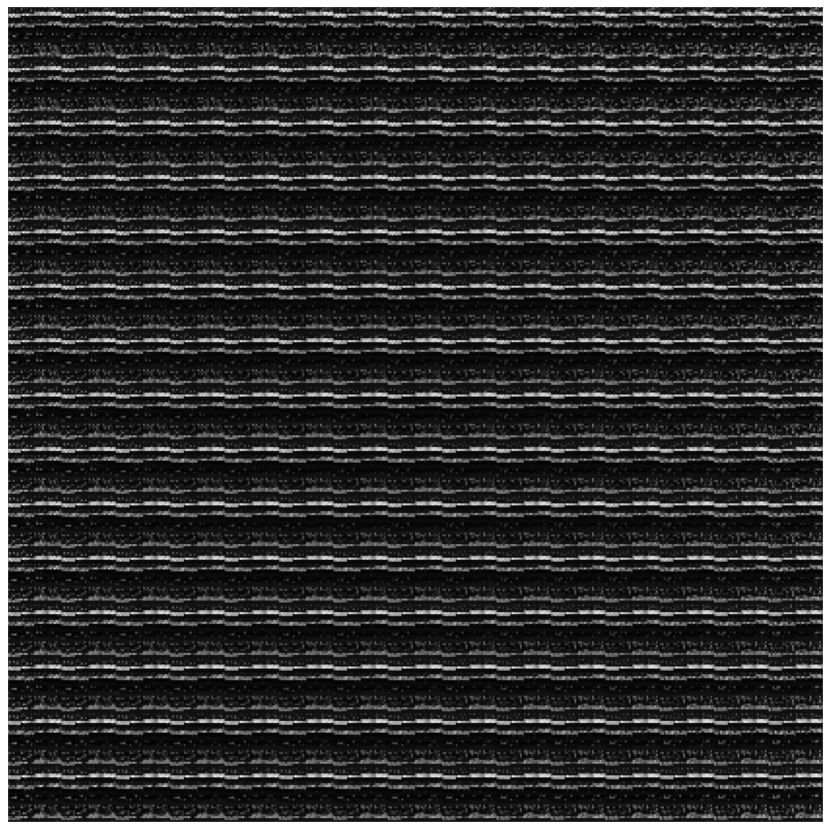

In [266]:
model.eval()
_img = draw_manifold(model, True)

In [0]:
def on_epoch_end(epoch):
    # Saving manifold and z distribution to build plots and animation afterwards
    figure = draw_manifold(model, show=False)
    reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)
    return figure, reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [0]:
def train(num_epochs):
    epochs, figs, latent_distrs = [], [], []
    for epoch_num in tqdm.tnrange(num_epochs):
        model.train()
        loss_accumulator = 0.
        bce_acc = 0.
        kl_acc = 0.
        for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):
            batch_x = batch_x.to(device)
            batch_label = batch_label.float().unsqueeze(-1).to(device)
            predictions, latent, mu_values, log_sigma_values = model(batch_x, batch_label)

            #kl_loss = # <YOUR CODE HERE>
            kl_loss = 0.5 * torch.mean(torch.sum(mu_values.pow(2) + torch.exp(log_sigma_values) - 1. - log_sigma_values, dim=1))
            
            bce_loss = 28*28*loss_func(predictions, batch_x)
            loss = (bce_loss + kl_loss)/2./28./28.
            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_accumulator += loss.item()/(len(train_loader.dataset))
            bce_acc += bce_loss.item()/(len(train_loader.dataset))
            kl_acc += kl_loss.item()/(len(train_loader.dataset))

        if epoch_num % 5 == 0:
            print('Epoch num: {}\nTraining loss={:.4f}, KL divergence={:.4f}, BCE Loss={:.4f}'.format(
                epoch_num,
                loss_accumulator,
                kl_acc,
                bce_acc
            ))
            model.eval()
            figure, reconstructed_repr_test, latent_sample_test, mu_values_test, log_sigma_values_test = on_epoch_end(epoch_num)
            epochs.append(epoch_num)
            figs.append(figure)
            latent_distrs.append((mu_values_test, log_sigma_values_test))
    return epochs, figs, latent_distrs

In [107]:
epochs, figs, latent_distrs = train(50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch num: 0
Training loss=0.0015, KL divergence=0.0015, BCE Loss=2.3127


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Epoch num: 5
Training loss=0.0012, KL divergence=0.0036, BCE Loss=1.9254


Epoch num: 10
Training loss=0.0011, KL divergence=0.0044, BCE Loss=1.7765


Epoch num: 15
Training loss=0.0011, KL divergence=0.0043, BCE Loss=1.6594


Epoch num: 20
Training loss=0.0010, KL divergence=0.0041, BCE Loss=1.5564


Epoch num: 25
Training loss=0.0009, KL divergence=0.0040, BCE Loss=1.4630


Epoch num: 30
Training loss=0.0009, KL divergence=0.0038, BCE Loss=1.3839


Epoch num: 35
Training loss=0.0008, KL divergence=0.0039, BCE Loss=1.3104


Epoch num: 40
Training loss=0.0008, KL divergence=0.0040, BCE Loss=1.2434


Epoch num: 45
Training loss=0.0008, KL divergence=0.0042, BCE Loss=1.1939


In [0]:
test_labels = []
for b in test_loader:
    test_labels.append(b[1])
test_labels = torch.cat(test_labels, dim=0).numpy()

In [109]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.8).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


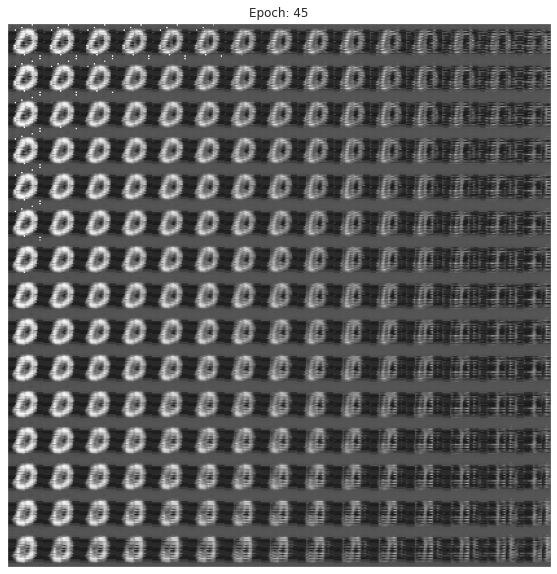

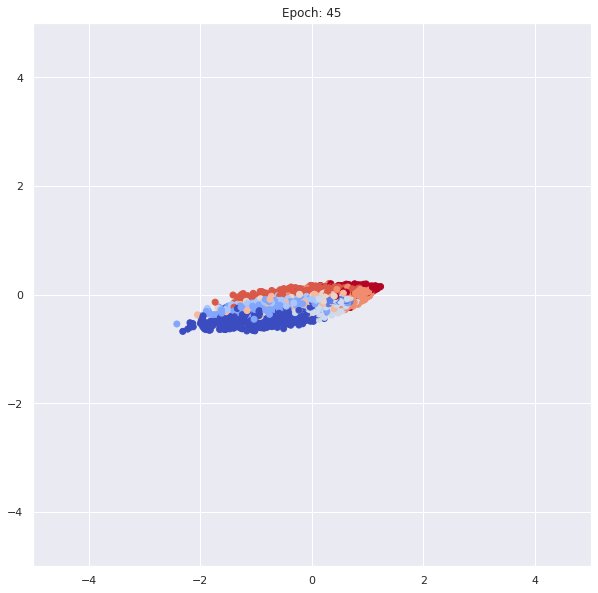

In [110]:
import os
os.makedirs('my_figs', exist_ok=True)

from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib

def make_2d_figs_gif(figs, epochs, fname, fig): 
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((28,28)), cmap='Greys_r', norm=norm)
    plt.grid(None)
    plt.title("Epoch: " + str(epochs[0]))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, dpi=80, writer='imagemagick')

def make_2d_scatter_gif(zs, epochs, c, fname, fig):
    im = plt.scatter(zs[0][:, 0], zs[0][:, 1], c=c, cmap=cm.coolwarm)
    plt.colorbar()
    plt.title("Epoch: " + str(epochs[0]))
    def update(i):
        fig.clear()
        im = plt.scatter(zs[i][:, 0], zs[i][:, 1], c=c, cmap=cm.coolwarm)
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(zs)), interval=150)
    anim.save(fname, dpi=80, writer='imagemagick')
    
make_2d_figs_gif(figs, epochs, "./my_figs/manifold2.gif", plt.figure(figsize=(10,10)))
make_2d_scatter_gif([x[0].numpy() for x in latent_distrs], epochs, test_labels, "./my_figs/z_distr2.gif", plt.figure(figsize=(10,10)))

You can find your brand gifs in `./my_figs/` directory ;)

Optionally you can also implement GAN for this task. Good luck!

##GAN на минималках

In [0]:
from torchvision import datasets
from torch.utils.data import DataLoader

mnist = datasets.MNIST(root='../data/', train=True, transform = mnist_transformations, download=True)
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)


In [0]:
class Discriminator(nn.Module):

    def __init__(self, input_size = 784, num_classes = 1):
        super(Discriminator, self).__init__()
        self.discriminator_layer = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.discriminator_layer(x)
        return x

class Generator(nn.Module):

    def __init__(self, input_size = 100, num_classes = 784):
        super(Generator, self).__init__()
        self.generator_layer = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.generator_layer(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

In [0]:
n = 100
lr = 0.0002
D = Discriminator().to(device)
G = Generator(n).to(device)

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (0.5, 0.999))

In [0]:
from matplotlib.pyplot import imshow

def get_image(G, n):

    z = torch.randn(100, n).to(device)
    y_hat = G(z).view(100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

if not os.path.exists('samples'):
    os.makedirs('samples')

Calculate discriminator and generator loss

In [166]:
step = 0
batch_size = 64
for epoch in range(50):
    for idx, (images, _) in enumerate(data_loader):
        x = images.to(device)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, torch.ones(batch_size, 1).to(device))

        z = torch.randn(batch_size, n).to(device)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, torch.zeros(batch_size, 1).to(device))
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % 1 == 0:
            z = torch.randn(batch_size, n).to(device)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, torch.ones(batch_size, 1).to(device))

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, D Loss: {}, G Loss: {}'.format(epoch, 49, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_image(G, n)
            imsave('samples/{}_step{}.jpg'.format('GAN', str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, D Loss: 0.5739932060241699, G Loss: 1.647875428199768
Epoch: 0/50, D Loss: 0.18691802024841309, G Loss: 22.516326904296875
Epoch: 1/50, D Loss: 0.20759272575378418, G Loss: 9.861302375793457
Epoch: 1/50, D Loss: 0.159459188580513, G Loss: 6.571943283081055
Epoch: 2/50, D Loss: 0.08478276431560516, G Loss: 7.388540744781494
Epoch: 2/50, D Loss: 0.1740570366382599, G Loss: 7.602459907531738
Epoch: 3/50, D Loss: 0.6900500059127808, G Loss: 6.089163780212402
Epoch: 3/50, D Loss: 0.10860709846019745, G Loss: 6.869489669799805
Epoch: 4/50, D Loss: 0.1273370087146759, G Loss: 6.599403381347656
Epoch: 4/50, D Loss: 0.0845256820321083, G Loss: 5.240063667297363
Epoch: 5/50, D Loss: 0.07601915299892426, G Loss: 6.246452331542969
Epoch: 5/50, D Loss: 0.13551458716392517, G Loss: 9.68376636505127
Epoch: 6/50, D Loss: 0.13538165390491486, G Loss: 6.6525163650512695
Epoch: 6/50, D Loss: 0.33487966656684875, G Loss: 12.051987648010254
Epoch: 7/50, D Loss: 0.1745397448539734, G Loss: 4.58

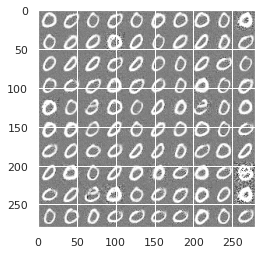

In [183]:
G.eval()
imshow(get_image(G, n), cmap='gray')